# 2 Compouse an expression matrix with the raw counts

Cynthia Soto <br>
Date: 5 de Octubre 2020 <br>
Last md: March 19th 2021 <br>

**Assumptions:** <br>
Data are expression RNASeq raw counts. e.g: files generated with HTSeq tool <br>
**This is a custom script to integrate several raw-count files from Arabidopsis (Col-0) Healthy and Infected.** <br>

**Workflow:** <br>
1) Compouse the expr matrix from a dataset of raw count files <br>
2) Get some stats and distributions.  <br> 
3) Remove genes with ceros across all samples.  <br>
4) And plot again.  <br>

In [183]:
# Libraries required
import os 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [148]:
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        
#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts


### Declare functions 

In [149]:
# Rename columns on  a df according to your story
def set_ID_samples_infected(df):
    df = df.rename(columns={'SRR10586397': 'Bc24', 'SRR364399':'Ch40.3','SRR364401':'Ch40',
                                         'SRR6283148':'Ss30','SRR6283147':'Ss30.1','SRR3383696':'Bc12',
                                         'SRR3383780':'Bc18','SRR6283146':'Ss30.2','SRR3383779':'Bc18.1',
                                         'SRR3383697':'Bc12.1','SRR364390':'Ch22','SRR364389':'Ch22.1',
                                         'SRR364400':'Ch40.1','SRR364391':'Ch22.2','SRR10586399':'Bc24.1',
                                         'SRR364392':'Ch22.3','SRR364398':'Ch40.2'})
    return df 
def set_ID_samples_healthy(df):
    df = df.rename(columns={'SRR3383821': 'healthy24', 'SRR3383783':'healthy18.1','SRR3383822':'healthy24.1',
                            'SRR3383640':'healthy12','SRR3383641':'healthy12.1','SRR6283145':'healthy30.1',
                            'SRR3383782':'healthy18','SRR6283144':'healthy30'})
    return df

In [150]:
# Set ID index as "ID" to a describe() function in a df
def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [151]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [152]:
# Filter a dataframe by the value of a column (I used to set a cutoff threshold)
def filter_df(df, *args):

    # Input: df is the dataframe to filter and *args are the criteria to apply
    # output: a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

### Integration to all data files (samples) in one matrix 

In [184]:
## check a bit of the files to be processed ... are they ok?
s_path = str(os.getcwd())+'/SRR*'  
all_files = glob.glob(s_path)
for file in all_files:
    print(file)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR6283145
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR6283144
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383640
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383783
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383782
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383822
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383641
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts/SRR3383821


### Integrate raw count files into a single dataframe (matrix)

In [155]:
all_files = glob.glob(s_path)
## To load the main df
flag_b=True

for file in all_files:
    #print(file)
    # get the base name from a 'linux path' 
    sample = os.path.basename(file)

    if flag_b:    ## load main df once
        ## Main df is df1
        df1=pd.read_csv(file, sep='\t')    ## nrows=100, usecols=[0,1]
        df1.columns = ["Genes","Counts"]
        print(df1.head(3))
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df1.drop(df1.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
        df1.rename(columns={'Counts':sample},inplace=True)
        #print(df1.head(3)) 
        flag_b=False
    else:
        #print(file)
        df2= pd.read_csv(file, sep='\t')    
        df2.columns = ["Genes","Counts"]
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df2.drop(df2.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df2.drop(df2.columns[df2.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)      
        ## compare matrix gene_names before concatenated
        comparison_column = np.where(df1["Genes"] == df2["Genes"], True, False)
        if (False in comparison_column):
            print("Gene_names are not the same. Matrix "+file+" will not be concatenated.")
        else:
            ## merge matrix based in column name "Genes"
            df2.rename(columns={'Counts':sample},inplace=True)
            df1=df1.merge(df2,on=['Genes'],how='left')
            

       Genes  Counts
0  AT1G01020     175
1  AT1G01030      20
2  AT1G01040    2541


In [156]:
df1.head(5)

,Genes,SRR6283145,SRR6283144,SRR3383640,SRR3383783,SRR3383782,SRR3383822,SRR3383641,SRR3383821
0,AT1G01020,175,163,108,117,224,92,267,145
1,AT1G01030,20,25,13,13,35,16,22,9
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684
4,AT1G01060,11,4,288,18184,32522,219,835,386


In [157]:
# call a function to set label sample's as IDs
df1 = set_ID_samples_healthy(df1)

## Some stats of the new df

1) Descriptive stats are calculate on the new df<br>
2) IDs of genes with cero counts across all the samples are identified and summarized.<br>
3) IDs identified are dropped from the the df to compose a new df filtered. <br>

In [159]:
df_plot=df1.describe().T
df_plot.head(5)

,count,mean,std,min,25%,50%,75%,max
healthy30.1,27654.0,632.671,2953.803,0.0,0.0,72.0,481.0,141108.0
healthy30,27654.0,706.560,4073.516,0.0,0.0,63.0,469.0,274644.0
healthy12,27654.0,347.674,1860.502,0.0,0.0,52.0,281.0,153437.0
healthy18.1,27654.0,452.536,3224.107,0.0,0.0,51.0,303.0,315702.0
healthy18,27654.0,954.305,7136.602,0.0,1.0,106.0,607.0,660692.0


In [160]:
## call the fuction df_with_label_ID
df_plot = df_with_label_ID(df_plot)
df_plot.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
2,healthy12,27654.0,347.674,1860.502,0.0,0.0,52.0,281.0,153437.0
6,healthy12.1,27654.0,716.372,3764.360,0.0,0.0,105.0,586.0,315017.0
4,healthy18,27654.0,954.305,7136.602,0.0,1.0,106.0,607.0,660692.0
3,healthy18.1,27654.0,452.536,3224.107,0.0,0.0,51.0,303.0,315702.0
7,healthy24,27654.0,481.767,2645.102,0.0,0.0,61.0,351.0,148426.0


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'healthy12'),
  Text(1, 0, 'healthy12.1'),
  Text(2, 0, 'healthy18'),
  Text(3, 0, 'healthy18.1'),
  Text(4, 0, 'healthy24'),
  Text(5, 0, 'healthy24.1'),
  Text(6, 0, 'healthy30'),
  Text(7, 0, 'healthy30.1')])

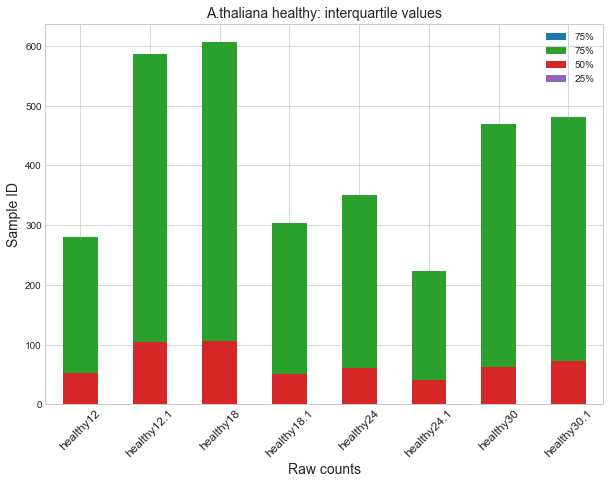

In [162]:
ax = df_plot.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
df_plot.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
df_plot.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
df_plot.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
plt.title('A.thaliana healthy: interquartile values',fontsize=14);
plt.xlabel('Raw counts',fontsize=14);
plt.ylabel('Sample ID',fontsize=14);
plt.xticks(rotation=45,fontsize=12)
#plt.show()

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


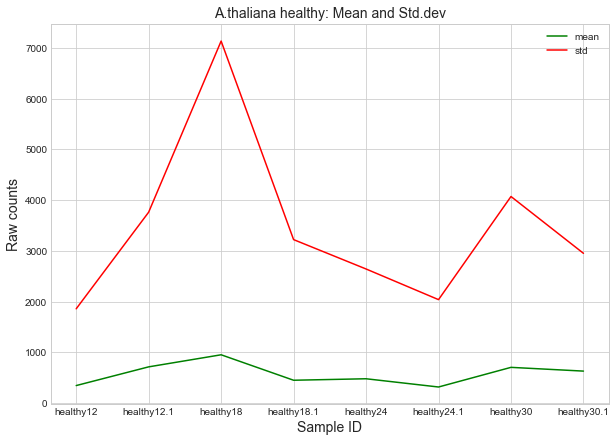

In [163]:
## gca stands for 'get current axis'
ax = plt.gca()
df_plot.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
df_plot.plot(kind='line',x='ID',y='std', color='red', ax=ax)
plt.title('A.thaliana healthy: Mean and Std.dev',fontsize=14);
plt.xlabel('Sample ID',fontsize=14);
plt.ylabel('Raw counts',fontsize=14);

### Check for genes with zeros across all samples

In [164]:
df1.head(5)

,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,AT1G01020,175,163,108,117,224,92,267,145
1,AT1G01030,20,25,13,13,35,16,22,9
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684
4,AT1G01060,11,4,288,18184,32522,219,835,386


In [165]:
## Check number of zeros by sample
sr_ceros = df1.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

## format the df (idx)
df_ceros.columns = df_ceros.iloc[0]
df_ceros = df_ceros.drop(df_ceros.index[0])
#df_ceros.head()

## call a function to set ID labels 
df_ceros = df_with_label_ID(df_ceros)
df_ceros.head(5)
#df_ceros.to_csv("../results-data/healthy_zeros_bysample.csv", index=False, header=True)

***Here, zeros are counted by genes across all samples & a new column with the zero-counter values is appended to the matrix*** <br>
We're going to create the file called: **all_healthy_counterOFzeros.csv** contains the counter of zeros by gene <br>


In [166]:
s_zeros=(df1 == 0).astype(int).sum(axis=1)
#print(s_zeros)
#type(s_zeros)    ### build a serie-pandas
## Desglozando la formula
#(df1 == 0)
#(df1 == 0).astype(int)
#(df1 == 0).sum(axis=1)

## Added a column to df1 with the counter of zeros
df1['zero-counter'] = s_zeros
df1
## Send the new matrix to all_log2_counter_cero.csv 
df1 = set_ID_samples(df1)
#df1.to_csv('../results-data/all_healthy_counterOFzeros.csv', sep='\t', index=False)

Here, we look for genes with n number of ceros <br>
We create the file called: **all_infected_genes_w n zeros.csv** contains the detail of these genes with cero counts across all samples <br>

In [167]:
## Filter is looking for genes with 8 ceros across all samples (we have 8 samples for control)
is_zero = (df1['zero-counter']>=8)     
df1_17 = df1[is_zero]
print(df1_17.shape)
df1_17.head(7)
## save the result as tmp result
#df1_17.to_csv('../results-data/tmp/all_healthy_genes_w8zeros.csv', sep='\t', index=False)

(5228, 10)


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
26,AT1G01280,0,0,0,0,0,0,0,0,8
29,AT1G01305,0,0,0,0,0,0,0,0,8
32,AT1G01335,0,0,0,0,0,0,0,0,8
40,AT1G01400,0,0,0,0,0,0,0,0,8
41,AT1G01410,0,0,0,0,0,0,0,0,8
47,AT1G01460,0,0,0,0,0,0,0,0,8
99,AT1G01980,0,0,0,0,0,0,0,0,8


### Trimming genes with zeros across all samples
Remove gene-IDs marked with no counts across all samples<br>
<br>
e.g: if the size of the set is 8 samples, then 8 is the maximum number of zeros that a gene can have, it is established that this gene had no expression in any of the samples. <br>

In [168]:
## Save the gene IDs with ceros in a file 
genes_cero_ToList = list(df1_17['Genes'])
with open("../results-data/all_healthy_geneIDs_with_zeros.csv", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))

In [169]:
## Here, we count how many genes are not expressed in all the samples
df1_17.isin([0]).sum().head()

Genes             0
healthy30.1    5228
healthy30      5228
healthy12      5228
healthy18.1    5228
dtype: int64

In [170]:
# call the function  ==== df_drop_idx_list ==== to get the index of the genes to remove (df1_17) from the df1
df1 = df_drop_idx_list(df1_17, df1)

In [171]:
print(df1.shape)
df1.head(5)

(22426, 10)


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,AT1G01020,175,163,108,117,224,92,267,145,0
1,AT1G01030,20,25,13,13,35,16,22,9,0
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018,0
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684,0
4,AT1G01060,11,4,288,18184,32522,219,835,386,0


### New stats of the filtered data

In [172]:
## Save the new df with the ID genes with 17 ceros across all samples removed.
#df1.to_csv('../results-data/all_healthy_raw_8ceros_drop.csv', sep='\t', index=False)

In [173]:
## Get some stats of the new matrix filtered of zeros in common
df_tmp = df1.describe().T
df_tmp.drop(df_tmp.tail(1).index,inplace=True) # drop last n rows / or first n rows (.head)
df_tmp 

,count,mean,std,min,25%,50%,75%,max
healthy30.1,22426.0,780.161,3262.507,0.0,12.0,174.0,644.00,141108.0
healthy30,22426.0,871.275,4507.605,0.0,11.0,159.0,638.00,274644.0
healthy12,22426.0,428.724,2057.596,0.0,12.0,109.0,366.00,153437.0
healthy18.1,22426.0,558.032,3572.027,0.0,11.0,113.0,398.00,315702.0
healthy18,22426.0,1176.774,7908.412,0.0,24.0,227.0,805.75,660692.0
healthy24.1,22426.0,393.805,2260.049,0.0,9.0,88.0,292.00,113771.0
healthy12.1,22426.0,883.375,4162.506,0.0,21.0,230.0,774.00,315017.0
healthy24,22426.0,594.077,2925.914,0.0,13.0,137.0,463.75,148426.0


In [174]:
## call a function to set ID to the accesions
df_tmp = df_with_label_ID(df_tmp)
df_tmp.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
2,healthy12,22426.0,428.724,2057.596,0.0,12.0,109.0,366.00,153437.0
6,healthy12.1,22426.0,883.375,4162.506,0.0,21.0,230.0,774.00,315017.0
4,healthy18,22426.0,1176.774,7908.412,0.0,24.0,227.0,805.75,660692.0
3,healthy18.1,22426.0,558.032,3572.027,0.0,11.0,113.0,398.00,315702.0
7,healthy24,22426.0,594.077,2925.914,0.0,13.0,137.0,463.75,148426.0


In [175]:
df_tmp.sort_values(by=['ID'], inplace=True)
df_tmp.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
2,healthy12,22426.0,428.724,2057.596,0.0,12.0,109.0,366.00,153437.0
6,healthy12.1,22426.0,883.375,4162.506,0.0,21.0,230.0,774.00,315017.0
4,healthy18,22426.0,1176.774,7908.412,0.0,24.0,227.0,805.75,660692.0
3,healthy18.1,22426.0,558.032,3572.027,0.0,11.0,113.0,398.00,315702.0
7,healthy24,22426.0,594.077,2925.914,0.0,13.0,137.0,463.75,148426.0


In [176]:
#df_tmp.to_csv("../results-data/statistics/all_raw_healthy_stats_noZeros.csv", index=False, header=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'healthy12'),
  Text(1, 0, 'healthy12.1'),
  Text(2, 0, 'healthy18'),
  Text(3, 0, 'healthy18.1'),
  Text(4, 0, 'healthy24'),
  Text(5, 0, 'healthy24.1'),
  Text(6, 0, 'healthy30'),
  Text(7, 0, 'healthy30.1')])

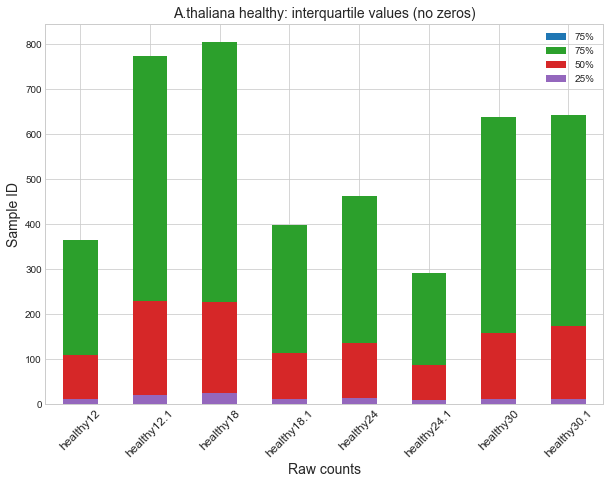

In [177]:
#plt.figure(figsize=(10,7))

ax = df_tmp.plot(x="ID", y="75%", kind="bar",figsize=(10,7))
df_tmp.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
df_tmp.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
df_tmp.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
plt.title('A.thaliana healthy: interquartile values (no zeros)',fontsize=14);
plt.xlabel('Raw counts',fontsize=14);
plt.ylabel('Sample ID',fontsize=14);
plt.xticks(rotation=45,fontsize=12)

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


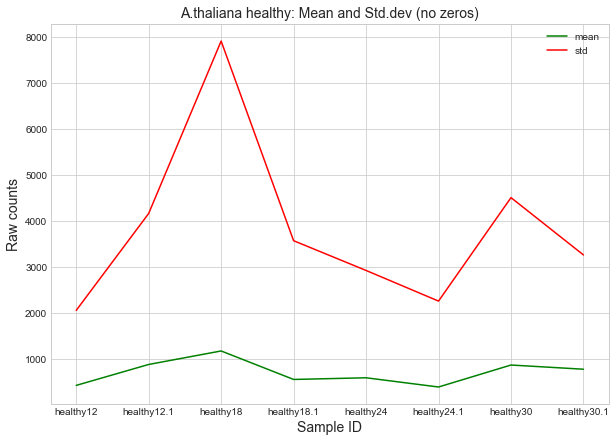

In [178]:
## gca stands for 'get current axis'
#plt.figure(figsize=(10,7))
ax = plt.gca()
df_tmp.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
df_tmp.plot(kind='line',x='ID',y='std', color='red', ax=ax)
plt.title('A.thaliana healthy: Mean and Std.dev (no zeros)',fontsize=14);
plt.xlabel('Sample ID',fontsize=14);
plt.ylabel('Raw counts',fontsize=14);

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'healthy12'),
  Text(1, 0, 'healthy12.1'),
  Text(2, 0, 'healthy18'),
  Text(3, 0, 'healthy18.1'),
  Text(4, 0, 'healthy24'),
  Text(5, 0, 'healthy24.1'),
  Text(6, 0, 'healthy30'),
  Text(7, 0, 'healthy30.1')])

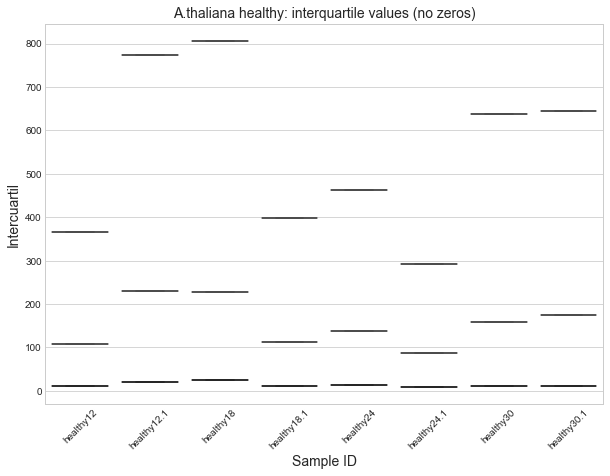

In [140]:
#df_tmp.head(5)
plt.figure(figsize=(10,7))
ax = plt.gca()
#Draw a vertical boxplot grouped by a categorical variable: 
#sns.set_style("whitegrid") 
ax = sns.boxplot(x = 'ID',y = '25%',data = df_tmp, color = 'green') 
ax = sns.boxplot(x = 'ID',y = '50%',data = df_tmp, color = 'yellow') 
ax = sns.boxplot(x = 'ID',y = '75%',data = df_tmp, color = 'red') 
plt.xlabel('Sample ID',fontsize=14);
plt.ylabel('Intercuartil',fontsize=14);
plt.title('A.thaliana healthy: interquartile values (no zeros)',fontsize=14)
plt.xticks(rotation=45)


In [179]:
## check Q1 , Q2 or Q3
col_ceros = df_tmp['75%'].tolist()
col_ceros.sort(reverse=False)
print(col_ceros)

[292.0, 366.0, 398.0, 463.75, 638.0, 644.0, 774.0, 805.75]


### Now explore the new distributions with no zeros across all samples
Plot all the sample in one plot (histogram and KDE)

In [180]:
# load file to be plotted
print(os.getcwd())
df_nozeros = pd.read_csv("../results-data/all_healthy_raw_8ceros_drop.csv", sep='\t')  
# dropping not-useful columns 
df_nozeros.drop(["Genes", "zero-counter"], axis = 1, inplace = True) 
print(df_nozeros.head(3))

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal1_htseq-counts
   healthy30.1  healthy30  healthy12  healthy18.1  healthy18  healthy24.1  \
0          175        163        108          117        224           92   
1           20         25         13           13         35           16   
2         2541       2492       1027         1324       2376          638   

   healthy12.1  healthy24  
0          267        145  
1           22          9  
2         2296       1018  


Plot both the histogram and densities in the same plot with the seaborn package (imported as sns) which allows you to do that via the distplot(). 
Since seaborn is built on top of matplotlib, you can use the sns and plt one after the other.

In [181]:
## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)
df_nozeros.head(5)

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,175,163,108,117,224,92,267,145
1,20,25,13,13,35,16,22,9
2,2541,2492,1027,1324,2376,638,2296,1018
3,1531,1804,850,1217,2664,406,1851,684
4,11,4,288,18184,32522,219,835,386


[20, 2541, 1531, 11, 39, 1280, 5079, 1458, 8]
[25, 2492, 1804, 4, 106, 1131, 6032, 1088, 31]
[13, 1027, 850, 288, 42, 975, 1281, 483, 10]
[13, 1324, 1217, 18184, 172, 981, 1799, 503, 10]
[35, 2376, 2664, 32522, 311, 2124, 3912, 1319, 22]
[16, 638, 406, 219, 61, 429, 962, 399, 14]
[22, 2296, 1851, 835, 80, 1927, 2801, 1060, 10]
[9, 1018, 684, 386, 216, 494, 1371, 581, 22]


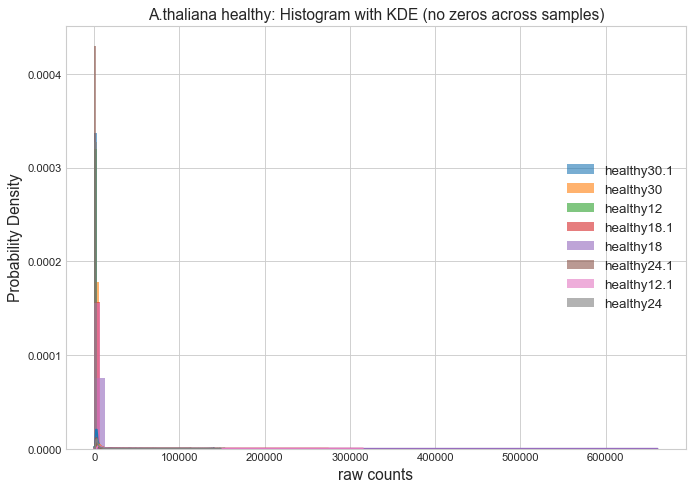

In [182]:
# Plot the distributions: values are raw data - not normalized 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_nozeros[file].tolist()
    print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('A.thaliana healthy: Histogram with KDE (no zeros across samples)',fontsize=14);
plt.xlabel('raw counts',fontsize=14);
plt.ylabel('Probability Density',fontsize=14);
## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=12);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");